#   Trabalho Computacional 2. Perceptron Multicamada no problema MNIST

> Nome: *Gabriel Martins Silveira de Oliveira*  
> Matrícula: 190042656


## Sumário

Neste projeto, será realizada a implementação de um modelo Perceptron Multicamadas (MLP), 
evoluindo a partir do conceito do Perceptron original.  
Todas as implementações utilizarão o conjunto de dados 
(dataset) MNIST, fornecido pela biblioteca PyTorch.

Serão exploradas as seguintes configurações e variações do modelo:

1.  **MLP com uma Camada Oculta e Otimizador SGD:**
    *   Implementação de um Perceptron Multicamadas com uma camada oculta contendo 128 neurônios.
    *   Utilização da função de ativação Sigmoide (logística) na camada oculta.
    *   Utilização da função de ativação Softmax na camada de saída (adequada para classificação multiclasse como o MNIST).
    *   Otimização realizada por meio da Descida de Gradiente Estocástico (SGD).

2.  **Otimizador Adam:**
    *   Substituição do otimizador SGD pelo Adam, que ajusta adaptativamente a taxa de aprendizado para cada parâmetro do modelo, visando uma convergência potencialmente mais eficiente.

3.  **Função de Ativação ReLU:**
    *   Substituição da função de ativação Sigmoide pela ReLU (Rectified Linear Unit) na(s) camada(s) oculta(s), analisando seu impacto no desempenho e na mitigação do problema de desaparecimento do gradiente.

4.  **Exploração de Arquiteturas Maiores:**
    *   Avaliação do impacto do aumento da capacidade do modelo através de:
        *   Um MLP com uma única camada oculta contendo 256 neurônios.
        *   Um MLP com duas camadas ocultas, cada uma contendo 128 neurônios.

## Compreendendo o Dataset

Para este projeto, utilizaremos o dataset MNIST, um conjunto de dados 
clássico para tarefas de classificação de imagens, fornecido pela biblioteca PyTorch.

O MNIST consiste em um total de 70.000 imagens de dígitos manuscritos (de 0 a 9). 
Essas imagens são divididas da seguinte forma:

*   **60.000 imagens** para o conjunto de **treinamento** do modelo.
*   **10.000 imagens** para o conjunto de **teste** (ou validação), utilizado para avaliar o desempenho do modelo treinado em dados não vistos.

Cada imagem no dataset:
*   Possui dimensões de **28x28 pixels**.
*   É representada em **tons de cinza**.
*   Está associada a um rótulo (label) que indica o dígito que ela representa, totalizando **10 classes distintas** (os dígitos de 0 a 9).

In [1]:
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

root = Path() / "data"
root.mkdir(parents=True, exist_ok=True)

MEAN_MNIST = (0.1307,)
STD_MNIST = (0.3081,)

num_workers = 4


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(MEAN_MNIST, STD_MNIST)]
)



train_dataset = datasets.MNIST(
    root=root, train=True, download=True, transform=transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,  # Tentei acelerar o processo, mas é lento de qualquer maneira
    pin_memory=True,
)



test_dataset = datasets.MNIST(
    root=root, train=False, download=True, transform=transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)


print("Dataset carregado!")

Dataset carregado!


In [2]:
print(
    f"Classes: {test_dataset.classes.__len__()}", 
    *test_dataset.classes, 
    sep="\n",
)

Classes: 10
0 - zero
1 - one
2 - two
3 - three
4 - four
5 - five
6 - six
7 - seven
8 - eight
9 - nine


In [3]:
examples = enumerate(train_loader)
batch_idx, (x, y) = next(examples)

print(
    f"{x.shape=}", 
    f"{y.shape=}", 
    sep="\n",
)

x.shape=torch.Size([64, 1, 28, 28])
y.shape=torch.Size([64])


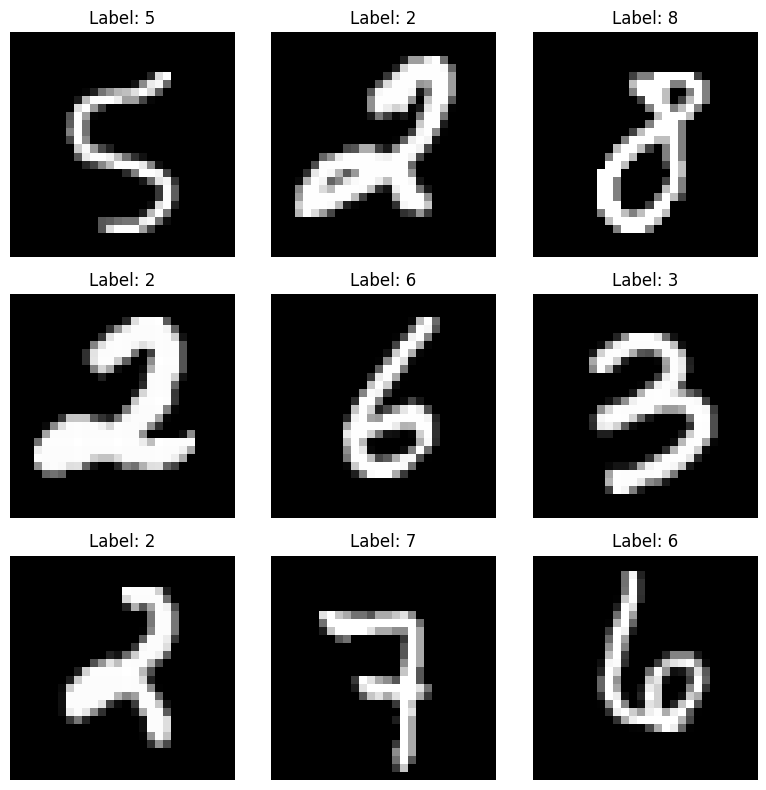

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for ax, i in zip(ax.flatten(), range(9)):
    ax.imshow(x[i][0], cmap="gray")
    ax.set_title(f"Label: {y[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Definição de Métodos

Para facilitar a experimentação e a organização do código ao longo deste projeto, 
serão definidos alguns métodos e uma classe base.

Inicialmente, será criada uma classe `BaseModel`, que herdará de `torch.nn.Module`.  
Esta classe servirá como um template para os modelos de Perceptron Multicamadas 
e permitirá encapsular funcionalidades comuns, tais como:

*   Definição dos conjuntos de dados (DataLoaders) de treinamento e validação.
*   Gerenciamento do dispositivo (CPU ou GPU via CUDA) onde os parâmetros do modelo e os cálculos serão processados.
*   Configuração do otimizador (por exemplo, SGD, Adam).
*   Especificação da função de perda (loss function) a ser utilizada (por exemplo, `CrossEntropyLoss`).

Em seguida, serão implementadas as seguintes funções:

1.  **Função de Treinamento Genérica:** Uma função que receberá uma instância da classe `BaseModel` (ou suas herdeiras) e os dados de treinamento, realizando o processo de ajuste dos pesos do modelo ao longo de um número definido de épocas.
2.  **Função de Avaliação/Validação:** Uma função que executará o modelo sobre o conjunto de dados de teste (ou validação), retornando as previsões geradas e os valores verdadeiros. Estes resultados serão utilizados para calcular métricas de desempenho.
3.  **Função de Cálculo de Acurácia:** Uma função específica para calcular a acurácia do modelo, comparando as previsões com os valores verdadeiros.

Por fim, será definida uma série de funções auxiliares para auxiliar na análise do desempenho e do comportamento dos modelos treinados. Estas incluirão:
*   **Função de Plotagem:** Para visualizar métricas como a perda (loss) e a acurácia ao longo das épocas de treinamento.
*   **Função para Visualizar a Matriz de Confusão:** Para entender melhor como o modelo classifica as diferentes classes e onde ocorrem os erros.
*   **Função de Análise Consolidada:** Uma função que poderá integrar as saídas das funções anteriores para gerar um relatório ou uma visualização mais completa do desempenho do modelo após o treinamento.

### Classe `BaseModel`

In [5]:
import torch

if torch.cuda.is_available():
    print("CUDA está disponível e será utilizada.")
else:
    print("CUDA não está disponível. Usaremos a CPU.")

class BaseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        self.train_loader = train_loader
        self.test_loader = test_loader
        
    def get_optimizer(self) -> torch.optim.Optimizer:
        raise NotImplementedError
    
    def get_loss_fn(self) -> torch.nn.Module:
        raise NotImplementedError

CUDA está disponível e será utilizada.


### Função de Treinamento Genérica

Esta função, além de receber uma instância do modelo (`BaseModel` ou uma de suas classes derivadas) e os dados de treinamento, também aceitará uma lista (ou array) `train_losses` como argumento. O propósito desta lista é registrar o valor da função de perda (loss) calculado sobre o conjunto de treinamento ao final de cada época. Isso permite que se acompanhe a evolução da perda, auxiliando na análise da convergência e do aprendizado do modelo ao longo do processo de treinamento.

In [6]:
def train(
    model: BaseModel,
    train_losses: list[float],
):
    data_loader = model.train_loader
    loss_fn = model.get_loss_fn()
    optmizer = model.get_optimizer()
    device = model.device
    model.train()
    current_loss = 0
    for data, target in data_loader:
        data: torch.Tensor = data  # Gosto de typehint
        target: torch.Tensor = target  # Talvez pese na performance
        
        data = data.to(device=device)
        target = target.to(device=device)

        optmizer.zero_grad(set_to_none=True)
        logits = model(data)
        loss: torch.Tensor = loss_fn(logits, target)
        loss.backward()
        optmizer.step()
        current_loss += loss.item()

    avg_loss = current_loss / len(data_loader)
    train_losses.append(avg_loss)

### Função de Avaliação/Validação

Esta função, além de receber o modelo (`BaseModel` ou uma de suas classes derivadas) e os dados do conjunto de validação (ou teste), também aceitará uma lista (ou array) `eval_losses` como argumento. Similarmente à função de treinamento, esta lista tem o propósito de registrar o valor da função de perda (loss) calculado sobre o conjunto de validação, permitindo o acompanhamento da generalização do modelo e a detecção de overfitting.

Ao final da sua execução sobre o conjunto de dados fornecido, a função retornará uma tupla contendo dois vetores `numpy.ndarray`:
1.  Um vetor com as **predições** (ou seja, as classes previstas pelo modelo para cada amostra do conjunto de avaliação).
2.  Um vetor com os **valores verdadeiros** (os rótulos reais das amostras do conjunto de avaliação).

Estes dois vetores são essenciais para o cálculo de métricas de desempenho, como a acurácia e a matriz de confusão.

In [7]:
import numpy as np


def val(
    model: BaseModel,
    eval_losses: list[float],
) -> tuple[np.ndarray, np.ndarray]:
    data_loader = model.test_loader
    loss_fn = model.get_loss_fn()
    device = model.device
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_targets = []
        current_loss = 0
        for data, target in data_loader:
            data: torch.Tensor = data  # Pode comentar fora
            target: torch.Tensor = target  # Pode comentar fora

            data = data.to(device=device)
            target = target.to(device=device)

            logits: torch.Tensor = model(data)
            loss: torch.Tensor = loss_fn(logits, target)
            current_loss += loss.item()

            pred = logits.argmax(dim=1)  # Predição sera o maior das 10 classes

            all_preds.append(pred.cpu().numpy())  # Essa parte pesa na performance
            all_targets.append(
                target.cpu().numpy()
            )  # A troca entre gpu e cpu faz essa função bem lenta

        avg_loss = current_loss / len(data_loader)
        eval_losses.append(avg_loss)

        return np.concatenate(all_targets), np.concatenate(all_preds)

### Função de Cálculo de Acurácia

Esta função é responsável por quantificar o desempenho do modelo em termos de acurácia. Para realizar o cálculo, ela necessita de duas entradas principais:
1.  As **predições** geradas pelo modelo (tipicamente a saída da camada final após a aplicação da função Softmax, indicando a classe prevista).
2.  Os **valores verdadeiros** (os rótulos corretos das amostras).

Com base na comparação entre as predições e os valores verdadeiros, a função calcula a proporção de acertos, que é o valor da acurácia.

Adicionalmente, de forma análoga ao registro das perdas, esta função também receberá uma lista (ou array) - por exemplo, `accuracies` - como argumento. O valor da acurácia recém-calculado será então adicionado a esta lista, permitindo o acompanhamento desta métrica ao longo de diferentes avaliações (como ao final de cada época de treinamento ou após a avaliação no conjunto de teste).

In [8]:
def get_acc(y: np.ndarray, pred: np.ndarray, accuracies: list):
    """Pega a Acuracia.
    Necessário alimentar com todo o vetor de treinamento.

    Args:
        y (Tensor): Valores verdadeiros
        pred (Tensor): Predição
    """

    correct_predictions = np.sum(y == pred)
    total_predictions = len(y)
    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)

### Funções de Análise

#### Configuração da Plotagem (Configura Plot)

Função auxiliar para definir configurações padrões ou iniciais dos gráficos, 
visando a organização do código e a consistência visual das plotagens.

In [9]:
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

def config_figure(
    ax1: Axes, ax2: Axes, num_epoches: int
) -> tuple[Line2D, Line2D, Line2D]:
    """
    Returns:
        tuple[Line2D, Line2D, Line2D]: `line_train_loss, line_test_loss, line_accuracy`
    """
    # --- Configuração Primeiro Plot ---
    ax1.set_title("Perda Média por Época")
    ax1.set_xlabel("Época")
    ax1.set_ylabel("Perda")
    ax1.set_xlim(0.5, num_epoches + 0.5)
    ax1.set_ylim(0, 2.5)
    line_train_loss, = ax1.plot([], [], "r-o", label="Perda Treinamento")
    line_test_loss, = ax1.plot([], [], "b-o", label="Perda Validação")
    ax1.legend(loc="upper left")

    # --- Configuração Segundo Plot ---
    ax2.set_title("Acurácia de Validação por Época")
    ax2.set_xlabel("Época")
    ax2.set_ylabel("Acurácia")
    ax2.set_xlim(0.5, num_epoches + 0.5)
    ax2.set_ylim(-0.1, 1.1)
    line_accuracy,  = ax2.plot([], [], "g-o", label="Acurácia Validação")
    ax2.legend(loc="lower right")
    plt.tight_layout()

    return line_train_loss, line_test_loss, line_accuracy


#### Atualização da Plotagem (Atualiza Plot)

Responsável por atualizar dinamicamente os gráficos que exibem a evolução da função de perda (loss) e da acurácia ao longo das épocas de treinamento ou avaliações.

In [10]:
def update_metrics_plot(
    ax1: Axes,
    line_train_loss: Line2D,
    line_test_loss: Line2D,
    line_accuracy: Line2D,
    current_epoche: int,
    train_losses: list[float],
    test_losses: list[float],
    accuracies: list[float],
):
    epoche_list = list(range(1, current_epoche + 1))
    # --- Atualiza as linhas ---
    line_train_loss.set_data(epoche_list, train_losses)
    line_test_loss.set_data(epoche_list, test_losses)
    line_accuracy.set_data(epoche_list, accuracies)

    # --- Ajusta o eixo y do plot de perdas ---
    overall_min = float("inf")
    overall_max = float("-inf")
    if train_losses:
        overall_min = min(overall_min, min(train_losses))
        overall_max = max(overall_max, max(train_losses))
    if test_losses:
        overall_min = min(overall_min, min(test_losses))
        overall_max = max(overall_max, max(test_losses))

    min_y = max(0, overall_min * 0.9) if overall_min != float("inf") else 0
    max_y = overall_max * 1.1 if overall_max != float("-inf") else ax1.get_ylim()[1]

    ax1.set_ylim(min_y, max_y)

#### Exibição da Matriz de Confusão (Printa Matrix de Confusão)

Função destinada a calcular e exibir a matriz de confusão. Esta visualização permite uma análise detalhada do desempenho do modelo na classificação de cada classe individualmente, identificando onde ocorrem os erros de classificação

In [11]:
import pandas as pd
from sklearn.metrics import confusion_matrix


def print_confusion_matrix(targets: np.ndarray, preds: np.ndarray):
    cm = confusion_matrix(targets, preds)
    class_names = [str(i) for i in range(10)]  # Espero que fiquem em ordem
    cm_df = pd.DataFrame(
        cm,
        index=[f"True_{n}" for n in class_names],
        columns=[f"Pred_{n}" for n in class_names],
    )
    print(cm_df)

#### Plotagem de Amostras Mal Classificadas (Plota mal classificados)

Função para visualizar algumas das amostras que foram classificadas incorretamente pelo modelo. Isso pode auxiliar na identificação de padrões nos erros ou dificuldades específicas do modelo.

In [12]:
from typing import Optional
from matplotlib.figure import Figure

def plot_miss_matches(
    targets: np.ndarray,
    preds: np.ndarray,
    test_loader: torch.utils.data.DataLoader = test_loader,
    num_to_show: int = 9
) -> Optional[Figure]:
    # find misclassified indices
    miss_idx = np.where(targets != preds)[0]
    if miss_idx.size == 0:
        print("Incrível, não houve classificação errada.")
        return None

    total_miss = len(miss_idx)
    print(f"Houveram {total_miss}/{len(targets)} classificações erradas!")
    actual = min(total_miss, num_to_show)
    print(f"--- {actual} exemplos de classificações incorretas. ---")

    all_imgs = []
    for batch_imgs, _ in test_loader:
        all_imgs.append(batch_imgs.cpu())
    all_imgs = torch.cat(all_imgs, dim=0)

    cols = 3
    rows = (actual + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 3))
    axes = np.atleast_1d(axes).flatten()

    for i in range(actual):
        idx = miss_idx[i]
        img = all_imgs[idx].squeeze().numpy()
        true_lbl = targets[idx]
        pred_lbl = preds[idx]

        ax: Axes = axes[i]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Verdadeiro: {true_lbl}\nPredição: {pred_lbl}")
        ax.axis("off")

    # hide any unused subplots
    for j in range(actual, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    return fig

#### Função de Análise Consolidada (Analiza)

Executa um conjunto de procedimentos de análise sobre o desempenho do modelo, tipicamente após um número específico de épocas de treinamento ou ao final do processo. Pode agregar resultados de outras funções de análise para fornecer um panorama geral.

In [13]:
from IPython.display import display, clear_output


def analyze(
    model: BaseModel,
    num_epoches: int,
    visualize_cm: bool = True,
    vizualize_missmatch: bool = True,
):
    train_losses = []
    test_losses = []
    accuracies = []

    print(
        f"Iniciando Treinamento, se faz uso de {model.device} para {num_epoches} épocas."
    )

    fig_metrics, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    line_train_loss, line_test_loss, line_accuracy = config_figure(
        ax1=ax1, ax2=ax2, num_epoches=num_epoches
    )

    for epoche in range(1, num_epoches + 1):
        # --- Começa o treinamento ---
        train(model=model, train_losses=train_losses)
        # --- Avalia o modelo ---
        targets_epoche, preds_epoche = val(model=model, eval_losses=test_losses)
        # --- Atualiza a Acuracia ---
        get_acc(y=targets_epoche, pred=preds_epoche, accuracies=accuracies)

        update_metrics_plot(
            ax1=ax1,
            line_train_loss=line_train_loss,
            line_test_loss=line_test_loss,
            line_accuracy=line_accuracy,
            current_epoche=epoche,
            train_losses=train_losses,
            test_losses=test_losses,
            accuracies=accuracies,
        )

        clear_output(wait=True)  # Limpa o display

        print(f"--- Época: {epoche}/{num_epoches} ---")
        print(
            f"  Train loss: {train_losses[-1]:.4f}",
            f"  Val loss: {test_losses[-1]:.4f}",
            f"  Val Accuracy: {accuracies[-1]:.4f}",
            sep="\n",
        )

        display(fig_metrics)  # Atualiza com o plot

    print("Treinamento finalizado.")
    if not (
        isinstance(targets_epoche, np.ndarray) and isinstance(preds_epoche, np.ndarray)
    ):  # Isso aqui é so para o pylance não encher o saco com type
        print("Algo esta extremamente errado.")
        raise TypeError("WTF")

    if vizualize_missmatch:
        miss_plot = plot_miss_matches(targets=targets_epoche, preds=preds_epoche)
        display(miss_plot)

    clear_output(wait=True)
    miss = len(np.where(targets_epoche != preds_epoche)[0])
    size = len(targets_epoche)
    print(
        f"--- Total de Épocas: {num_epoches:_} ---",
        f"--- Houveram {miss:_}/{size:_} Exemplos classificados incorretamente ---",
        f"  Train loss: {train_losses[-1]:.4f}",
        f"  Val loss: {test_losses[-1]:.4f}",
        f"  Val Accuracy: {accuracies[-1]:.4f}\n",
        sep="\n",
    )
    if visualize_cm:
        print("Matrix Confusão para ultimo set de treinamento.")
        print_confusion_matrix(targets=targets_epoche, preds=preds_epoche)

## Explorando Modelos

Nesta seção, serão analisados os diferentes modelos de Perceptron Multicamadas propostos para este projeto, avaliando suas arquiteturas e configurações específicas.

### MLP com uma Camada Oculta e Otimizador SGD

Este primeiro modelo consiste em um Perceptron Multicamadas (MLP) com as seguintes características:

*   **Arquitetura:** Contém uma única camada oculta.
    *   Uma camada oculta com 128 neurônios e função de ativação Sigmoide.  
*   **Otimizador:** Utiliza a Descida de Gradiente Estocástico (SGD).
    *   **Taxa de Aprendizado (Learning Rate):** Definida em 0.1, um valor relativamente alto (ou "agressivo").
*   **Função de Perda (Loss Function):** Emprega a Entropia Cruzada (Cross-Entropy Loss), adequada para problemas de classificação multiclasse.

--- Total de Épocas: 15 ---
--- Houveram 268/10_000 Exemplos classificados incorretamente ---
  Train loss: 0.0606
  Val loss: 0.0852
  Val Accuracy: 0.9732

Matrix Confusão para ultimo set de treinamento.
        Pred_0  Pred_1  Pred_2  Pred_3  Pred_4  Pred_5  Pred_6  Pred_7  \
True_0     969       0       1       2       0       2       4       1   
True_1       0    1122       2       1       0       1       5       1   
True_2       6       1    1003       2       4       0       4       7   
True_3       0       0       4     991       1       2       0       7   
True_4       2       0       0       0     957       1       5       1   
True_5       5       1       0      15       2     853       7       2   
True_6       6       3       1       0       3       6     935       0   
True_7       2       6      13       2       2       0       0     996   
True_8       4       1       2       5       5       4       4       7   
True_9       5       3       1      10      12       1

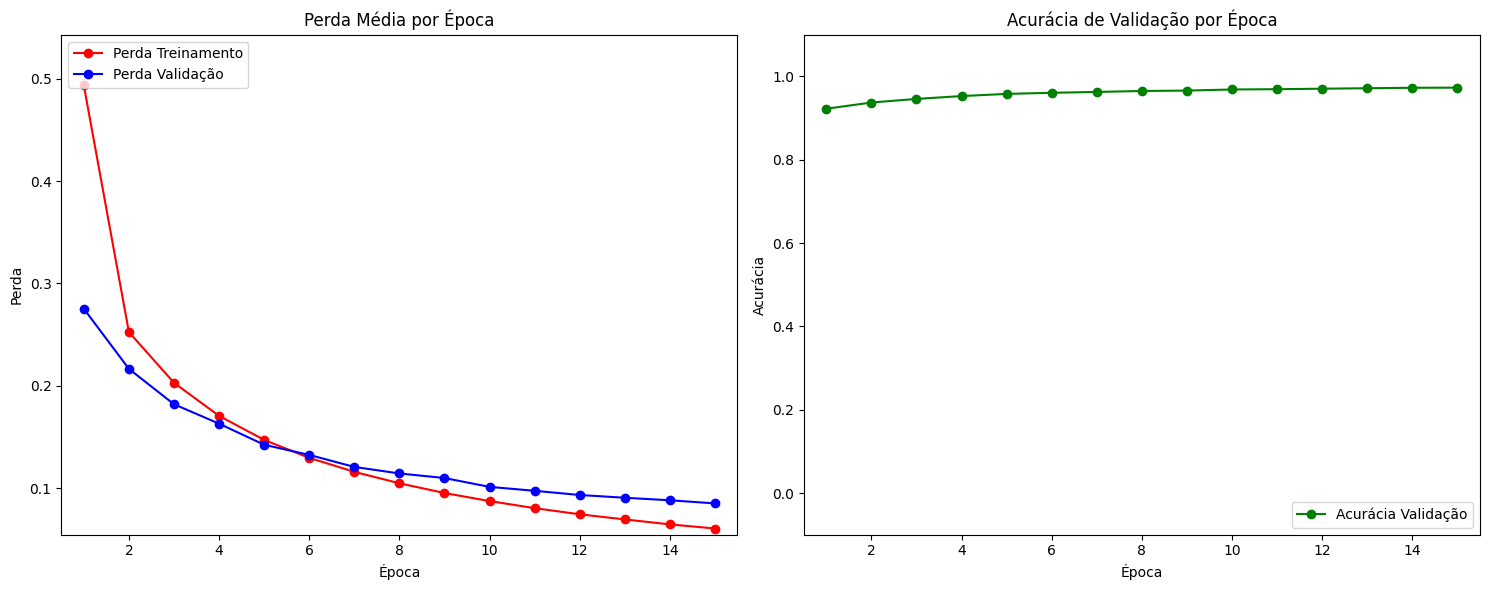

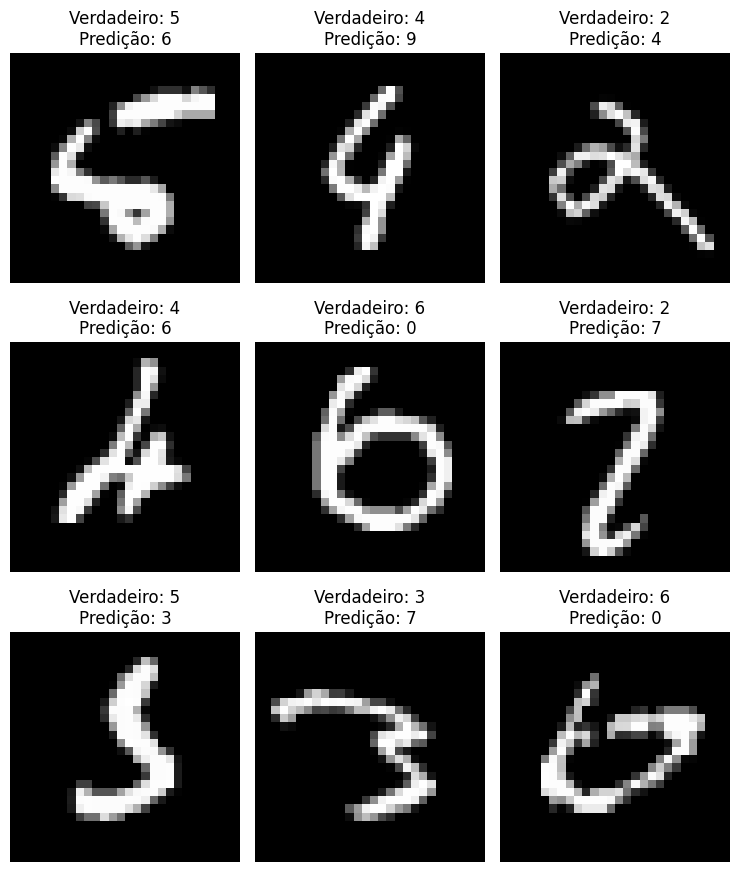

In [14]:
from torch import nn
from torch import optim

class FirstModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.Sigmoid(),
            nn.Linear(128, 10),
        )
        self.to(self.device)
        
    def forward(self, x):
        return self.model(x)
    
    def get_optimizer(self) -> optim.Optimizer:
        return optim.SGD(self.parameters(), lr=0.1)
    
    def get_loss_fn(self) -> nn.Module:
        return nn.CrossEntropyLoss()
    
model = FirstModel()
analyze(model=model, num_epoches=15)

A acurácia alcançada foi excepcional, superando as expectativas iniciais para um modelo com estas características. A análise da curva da função de perda revela que a taxa de aprendizado (learning rate), embora inicialmente considerada agressiva (0.1), demonstrou-se apropriada. Isso se evidencia pela descida consistente e suave da curva de perda durante o treinamento, indicando uma convergência estável. Adicionalmente, a trajetória da curva sugere que o modelo poderia se beneficiar de um treinamento com mais épocas, visando otimizar ainda mais seu desempenho.

### Otimizador Adam

No segundo modelo proposto, o otimizador de Descida de Gradiente Estocástico (SGD) utilizado anteriormente será substituído pelo otimizador Adam. O objetivo desta alteração é avaliar o impacto de um otimizador adaptativo no processo de treinamento e no desempenho final do modelo.

--- Total de Épocas: 15 ---
--- Houveram 242/10_000 Exemplos classificados incorretamente ---
  Train loss: 0.0138
  Val loss: 0.0818
  Val Accuracy: 0.9758

Matrix Confusão para ultimo set de treinamento.
        Pred_0  Pred_1  Pred_2  Pred_3  Pred_4  Pred_5  Pred_6  Pred_7  \
True_0     970       0       2       2       0       2       1       1   
True_1       0    1126       2       1       0       1       2       1   
True_2       3       3    1004       7       3       0       2       3   
True_3       0       0       2     995       1       1       0       4   
True_4       1       0       2       1     960       0       5       1   
True_5       4       1       2      12       2     857       4       1   
True_6       5       3       3       1       3       3     936       0   
True_7       1       5      10      10       3       0       0     975   
True_8       2       1       2       5       4       3       2       2   
True_9       2       2       1       6      11       1

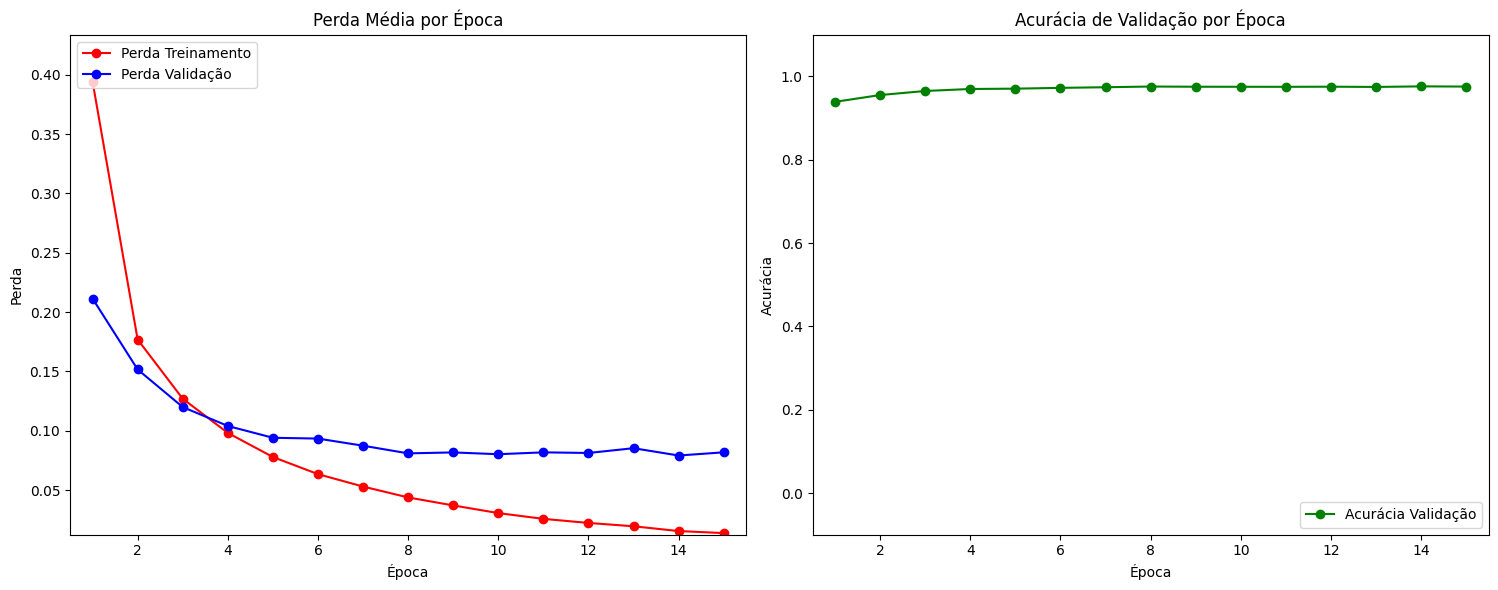

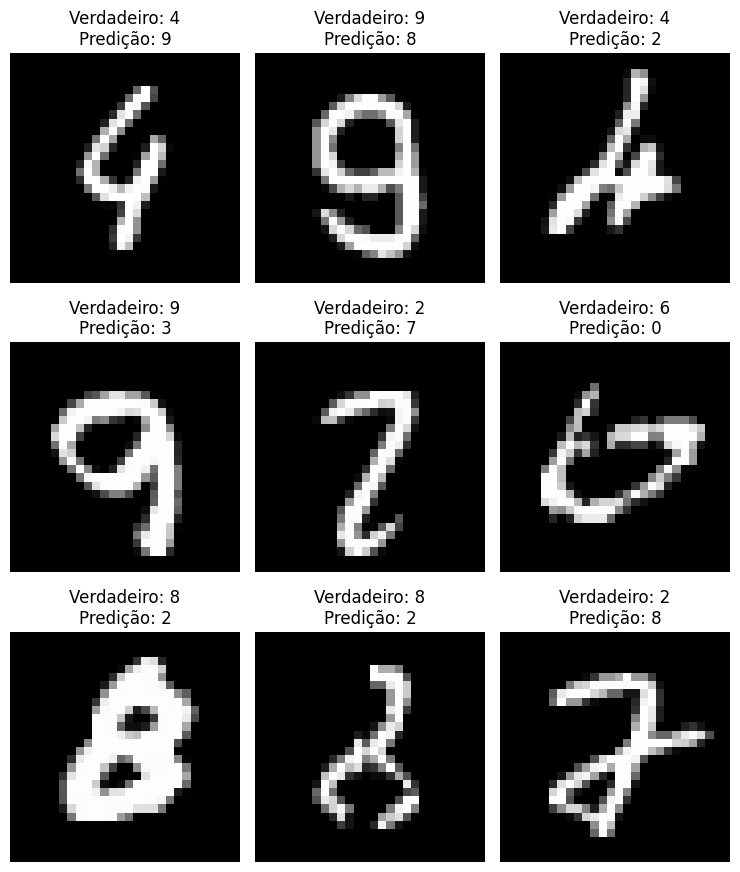

In [15]:
class SecondModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.Sigmoid(),
            nn.Linear(128, 10),
        )
        self.to(self.device)
        
    def forward(self, x):
        return self.model(x)
    
    def get_optimizer(self) -> optim.Optimizer:
        return optim.Adam(self.parameters())
    
    def get_loss_fn(self) -> nn.Module:
        return nn.CrossEntropyLoss()
    
model = SecondModel()
analyze(model=model, num_epoches=15)

Similarmente ao primeiro modelo, o segundo modelo (utilizando o otimizador Adam) também apresentou uma curva de erro consistentemente descendente durante o treinamento, indicando uma boa convergência. Da mesma forma, sugere-se que um aumento no número de épocas de treinamento poderia levar a um desempenho ainda melhor.

Em termos de acurácia, observou-se uma melhora, ainda que sutil, em comparação com o modelo anterior. Notavelmente, essa ligeira superioridade na acurácia demonstrou-se consistente ao longo das avaliações.

### Função de Ativação ReLU

Nesta variação do modelo, a função de ativação Sigmoide utilizada nas camadas ocultas dos modelos anteriores será substituída pela função de ativação ReLU (Rectified Linear Unit). O objetivo é observar e analisar o impacto dessa alteração no comportamento do treinamento e no desempenho final do modelo em comparação com as implementações que utilizam a Sigmoide.

--- Total de Épocas: 15 ---
--- Houveram 233/10_000 Exemplos classificados incorretamente ---
  Train loss: 0.0130
  Val loss: 0.1204
  Val Accuracy: 0.9767

Matrix Confusão para ultimo set de treinamento.
        Pred_0  Pred_1  Pred_2  Pred_3  Pred_4  Pred_5  Pred_6  Pred_7  \
True_0     972       0       1       0       0       1       4       0   
True_1       0    1127       2       2       0       1       1       1   
True_2       3       4     999       3       5       0       5       6   
True_3       1       0       4     981       0       6       0       6   
True_4       3       0       3       0     962       0       3       3   
True_5       3       0       0       7       1     867       7       1   
True_6       6       3       2       0       5       3     935       0   
True_7       1       2       7       1       2       0       1    1002   
True_8       7       0       2       3       6       1       5       2   
True_9       4       3       0       3      10       3

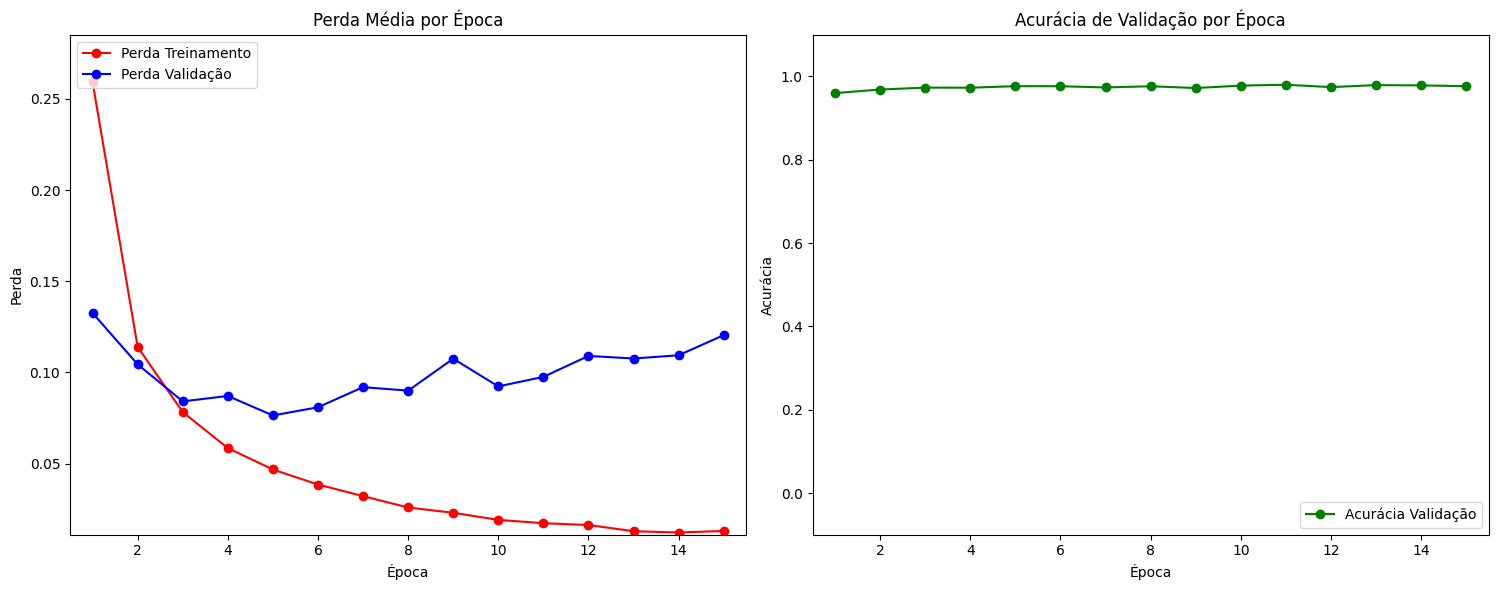

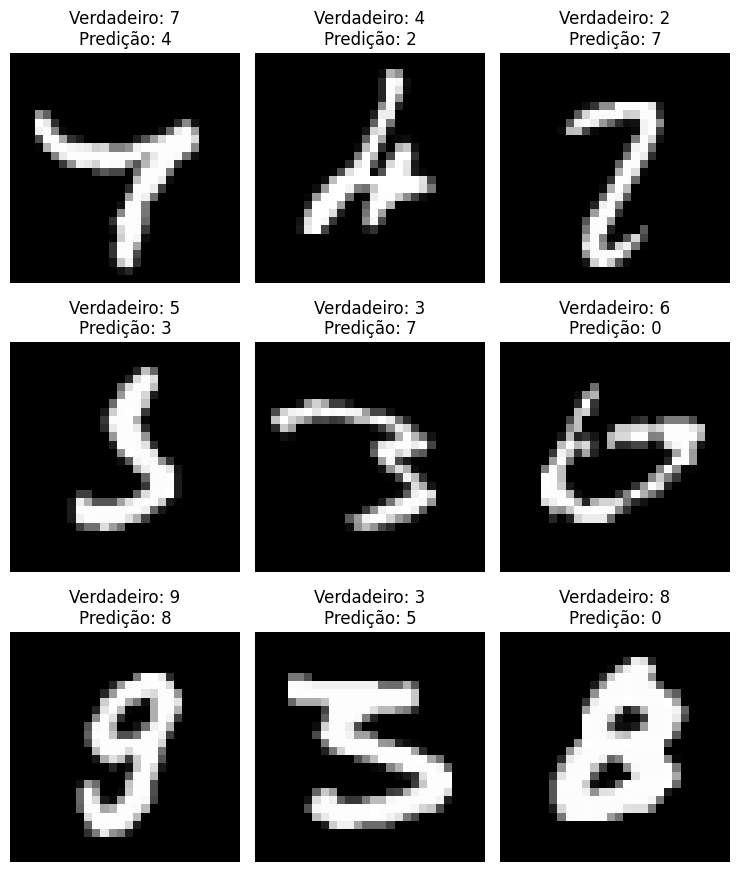

In [16]:
class ThirdModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
        self.to(self.device)
        
    def forward(self, x):
        return self.model(x)
    
    def get_optimizer(self) -> optim.Optimizer:
        return optim.Adam(self.parameters())
    
    def get_loss_fn(self) -> nn.Module:
        return nn.CrossEntropyLoss()
    
model = ThirdModel()
analyze(model=model, num_epoches=15)

Em linha com os resultados dos modelos anteriores, a curva de perda desta configuração (utilizando ReLU) também demonstrou uma trajetória de boa convergência. Observou-se, novamente, um incremento na acurácia. Embora este aumento tenha sido de pequena magnitude, sua consistência ao longo das avaliações o torna um resultado notável.

### Uma Camada Oculta com o Dobro de Neurônios

Nesta etapa da experimentação, mantendo as otimizações implementadas anteriormente (como o otimizador Adam e a função de ativação ReLU, por exemplo), a arquitetura do modelo será modificada para incluir o dobro da quantidade de neurônios na sua única camada oculta. O objetivo é investigar se o aumento da capacidade representacional do modelo, por meio de uma camada oculta mais ampla, resulta em alguma vantagem perceptível no desempenho de classificação.

--- Total de Épocas: 15 ---
--- Houveram 218/10_000 Exemplos classificados incorretamente ---
  Train loss: 0.0155
  Val loss: 0.1268
  Val Accuracy: 0.9782

Matrix Confusão para ultimo set de treinamento.
        Pred_0  Pred_1  Pred_2  Pred_3  Pred_4  Pred_5  Pred_6  Pred_7  \
True_0     967       1       2       0       0       2       2       1   
True_1       0    1120       4       0       0       0       0       0   
True_2       3       0    1007       9       3       0       0       2   
True_3       0       0       1    1001       0       1       0       0   
True_4       1       0       2       2     959       1       3       0   
True_5       1       0       0      14       1     865       4       0   
True_6       4       2       0       1       4       4     937       0   
True_7       2       4      12       7       1       0       0     987   
True_8       0       0       1       5       1       3       2       1   
True_9       2       2       0       6       6       4

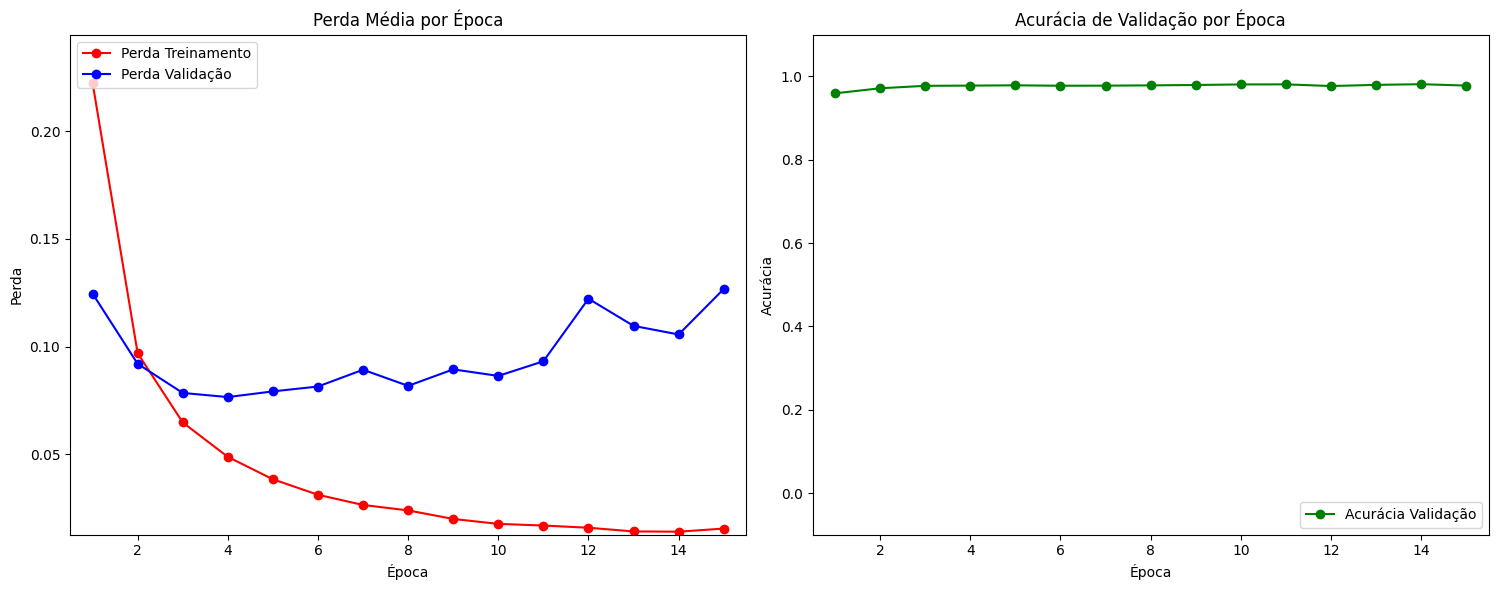

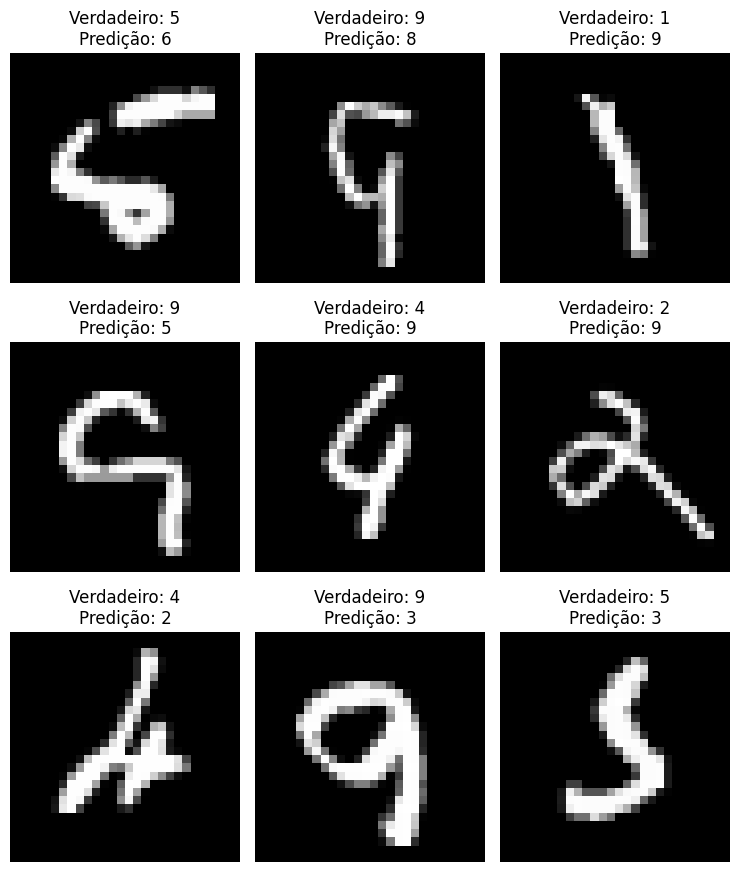

In [17]:
class FourthModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )
        self.to(self.device)
        
    def forward(self, x):
        return self.model(x)
    
    def get_optimizer(self) -> optim.Optimizer:
        return optim.Adam(self.parameters())
    
    def get_loss_fn(self) -> nn.Module:
        return nn.CrossEntropyLoss()
    
model = FourthModel()
analyze(model=model, num_epoches=15)

O desempenho em termos de acurácia deste modelo mostrou-se comparável ao do exemplo anterior. Contudo, ao analisar a curva de perda no conjunto de validação, é possível notar que esta começa a aplainar (ou estabilizar-se). Este comportamento pode ser um sinal precoce de overfitting, sugerindo que o modelo poderia começar a memorizar os dados de treinamento em detrimento da generalização, caso o treinamento fosse estendido por um número maior de épocas.

### Modelo com Duas Camadas Ocultas

Nesta configuração, avançando na exploração de arquiteturas mais profundas, será implementado um Perceptron Multicamadas com duas camadas ocultas. Ambas as camadas ocultas serão compostas por 128 neurônios cada. Para esta implementação, serão mantidos os princípios e otimizações adotados nos modelos anteriores bem-sucedidos, como o uso do otimizador Adam e da função de ativação ReLU (ou as configurações que se mostraram mais eficazes até o momento).

O objetivo é avaliar se a adição de profundidade à rede, por meio de uma segunda camada oculta, pode levar a uma melhoria na capacidade de aprendizado de representações mais complexas dos dados e, consequentemente, a um desempenho superior em comparação com os modelos de camada oculta única.

--- Total de Épocas: 15 ---
--- Houveram 235/10_000 Exemplos classificados incorretamente ---
  Train loss: 0.0185
  Val loss: 0.1402
  Val Accuracy: 0.9765

Matrix Confusão para ultimo set de treinamento.
        Pred_0  Pred_1  Pred_2  Pred_3  Pred_4  Pred_5  Pred_6  Pred_7  \
True_0     973       0       0       0       0       0       5       1   
True_1       0    1128       0       1       0       1       2       1   
True_2       5       2     993       5       0       0       5      10   
True_3       1       0       3     976       0      14       0      10   
True_4       3       1       1       0     948       1       9       2   
True_5       3       0       0       2       1     872       9       0   
True_6       4       2       0       1       2       1     947       0   
True_7       1       4       6       1       2       0       1    1001   
True_8       6       1       1       1       1       1       8       2   
True_9       4       3       0       1       6       7

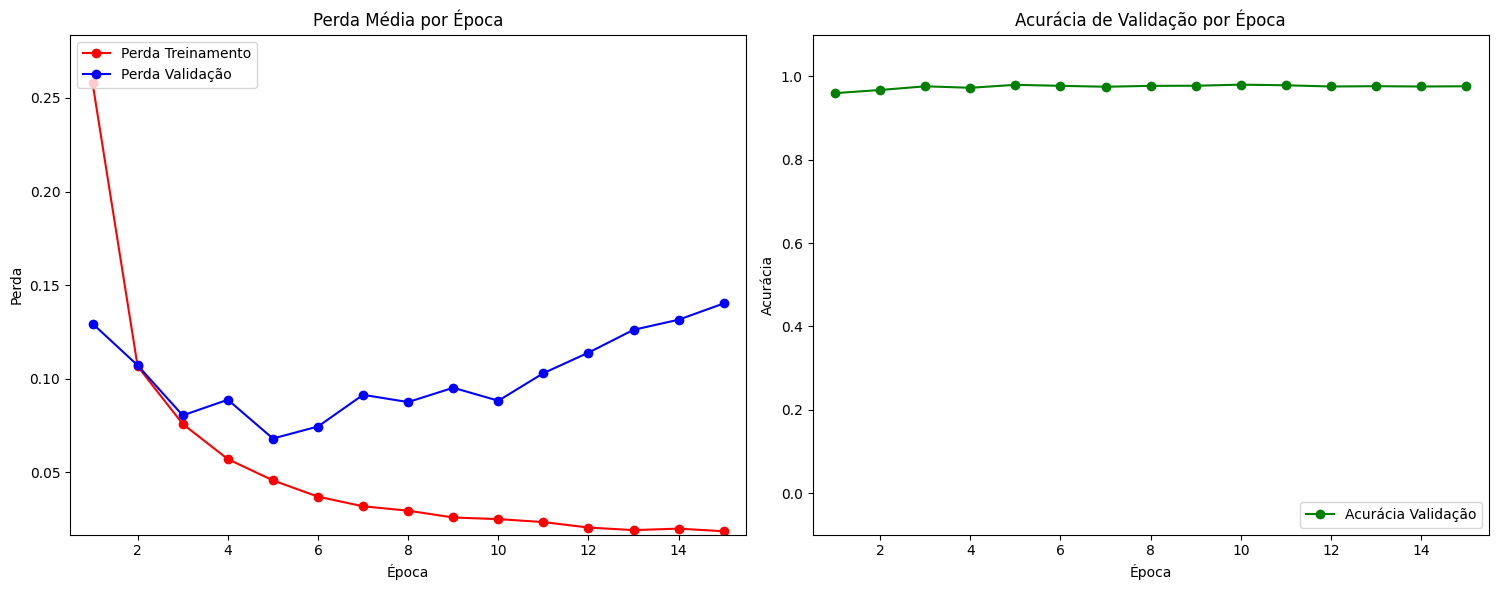

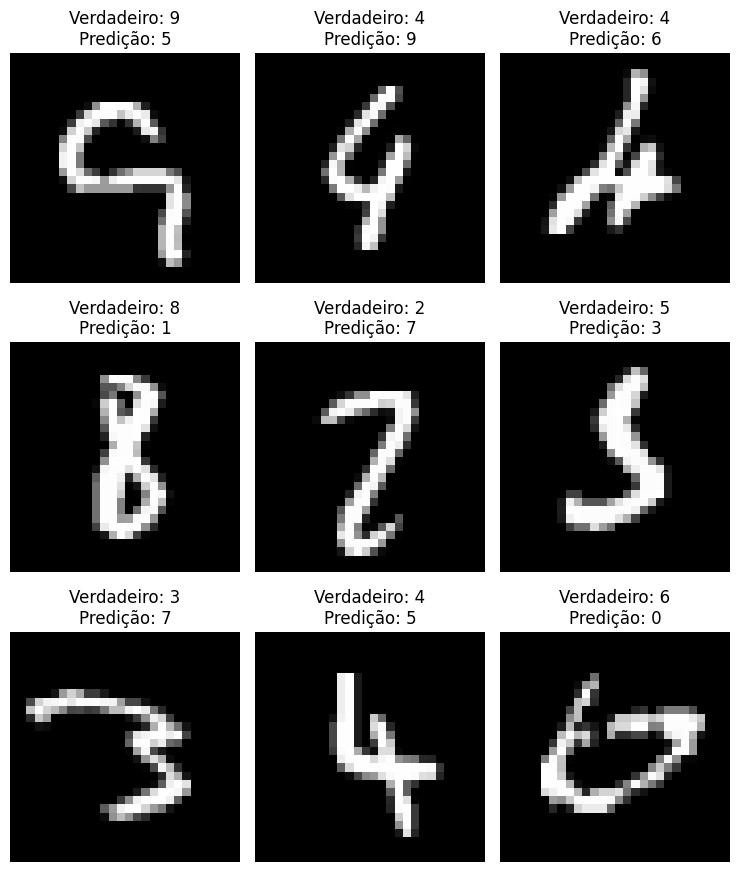

In [18]:
class FifthModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
        self.to(self.device)
        
    def forward(self, x):
        return self.model(x)
    
    def get_optimizer(self) -> optim.Optimizer:
        return optim.Adam(self.parameters())
    
    def get_loss_fn(self) -> nn.Module:
        return nn.CrossEntropyLoss()
    
model = FifthModel()
analyze(model=model, num_epoches=15)

O desempenho em termos de acurácia desta configuração mostrou-se, novamente, similar ao do modelo anterior. No entanto, ao analisar a curva de perda no conjunto de validação para este modelo de duas camadas ocultas, a tendência à estabilização (ou aplainamento) tornou-se visivelmente mais pronunciada.

Este comportamento é um indicativo mais claro de um possível início de overfitting em comparação com as configurações anteriores. Sugere que o modelo, com sua maior capacidade, pode estar começando a se ajustar excessivamente aos dados de treinamento, e um treinamento prolongado poderia não resultar em melhorias na generalização, podendo até mesmo degradá-la.

## Bônus: Potencial Aplicação ao Dataset Winequality

Considerando o trabalho desenvolvido anteriormente com o dataset Winequality, surge uma questão pertinente: a aplicação dos modelos de Perceptron Multicamadas (MLP), explorados neste projeto com o dataset MNIST, poderia resultar em um ganho de desempenho excepcional para a tarefa de classificação da qualidade dos vinhos?

### Tratamento de Dados do Dataset Winequality

Para preparar o dataset Winequality para a aplicação dos modelos de Perceptron Multicamadas, serão realizadas as seguintes etapas de pré-processamento de dados:

1.  **Tratamento de Valores Ausentes (Missing Values):**
    *   Conforme análises anteriores (ou como uma premissa para este exercício), assume-se que o dataset Winequality pode conter valores faltantes.
    *   Dado que se espera que estes representem uma pequena porcentagem do total de dados, a estratégia de imputação adotada será o preenchimento dos valores ausentes com a **média** da respectiva coluna numérica.

2.  **Codificação de Variáveis Categóricas (One-Hot Encoding):**
    *   A coluna `type` (que usualmente distingue entre vinho tinto e branco) é de natureza categórica.
    *   Para torná-la utilizável pelo modelo de rede neural, será aplicada a técnica de **One-Hot Encoding**.
    *   Durante este processo, o parâmetro `drop_first=True` será utilizado. Isso significa que, se a coluna `type` tiver `k` categorias, ela será convertida em `k-1` novas colunas binárias, ajudando a evitar problemas de multicolinearidade.

3.  **Normalização das Features:**
    *   Todas as colunas de features (variáveis preditoras), incluindo as novas colunas numéricas binárias resultantes do One-Hot Encoding da coluna `type`, passarão por um processo de **normalização**.
    *   A normalização ajusta os valores das features para uma escala comum (por exemplo, entre 0 e 1, ou com média 0 e desvio padrão 1), o que é crucial para o treinamento eficiente de redes neurais, pois ajuda na convergência do otimizador e evita que features com magnitudes maiores dominem o processo de aprendizado.
    *   *(Observação: Seria ideal especificar qual técnica de normalização será usada, por exemplo, Min-Max Scaling ou Standardization/Z-score normalization, se já estiver definida).*

In [19]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

DATASET_NAME = "winequalityN.csv"

wine_data_folder = Path() / "data" / "wine"
wine_data_folder.mkdir(parents=True, exist_ok=True)
wine_data_local = wine_data_folder / DATASET_NAME

df = pd.read_csv(wine_data_local)
# One Hot
df = pd.get_dummies(df, columns=["type"], dtype=float, drop_first=True)
# Ausentes
df = df.fillna(df.mean())
# Label para o pytorch
df["label"] = df["quality"] - df["quality"].min()

feat_cols = [col for col in df.columns if col not in ("quality", "label")]
X = df[feat_cols].values
y = df["label"].values
a = df["quality"].values # Isto serve para medir a acuracia trivial

quality_mean = df["quality"].mean().__round__() # Media arredondada

print(f"Tamanho da coluna de features: {feat_cols.__len__()}")
print(f"Tamanho do vetor de saida: {df["label"].unique().__len__()}")

# Divisão de teste
X_train, X_test, y_train, y_test, _, a = train_test_split(
    X, y, a, test_size=0.2, random_state=37
)

# Normalização
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Predição trivial

triv_pred = np.full_like(y_test, quality_mean)
acc = []
get_acc(y=a, pred=triv_pred, accuracies=acc)
print(f"Acuracia Trivial: {acc[0]:.4f}")

# Para tensor
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test)

print(
    f"{X_train.shape=}",
    f"{X_test.shape=}",
    f"{y_train.shape=}",
    f"{y_test.shape=}",
    sep="\n",
)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=num_workers, pin_memory=True
)


test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(
    test_dataset, batch_size=1300, shuffle=False, num_workers=num_workers, pin_memory=True
)

Tamanho da coluna de features: 12
Tamanho do vetor de saida: 7
Acuracia Trivial: 0.4362
X_train.shape=torch.Size([5197, 12])
X_test.shape=torch.Size([1300, 12])
y_train.shape=torch.Size([5197])
y_test.shape=torch.Size([1300])


### Testando Diferentes Arquiteturas de MLP no Dataset Winequality

Para avaliar o desempenho dos Perceptrons Multicamadas no dataset Winequality, serão testadas as seguintes arquiteturas, partindo de um modelo base e aumentando progressivamente sua complexidade:

1.  **Modelo Linear (Regressão Logística via MLP):**
    *   Esta será a implementação mais simples, consistindo em um modelo linear sem camadas ocultas. Essencialmente, funcionará de forma análoga a uma Regressão Logística, servindo como um baseline para os modelos mais complexos.

2.  **MLP com Uma Camada Oculta (12 Neurônios):**
    *   Um modelo com uma única camada oculta contendo 12 neurônios. Esta configuração introduz a capacidade de aprendizado não-linear.

3.  **MLP com Uma Camada Oculta (32 Neurônios) e Dropout:**
    *   Este modelo também possui uma única camada oculta, mas com uma capacidade maior (32 neurônios).
    *   Além disso, será incorporada a técnica de regularização **Dropout** para ajudar a prevenir o overfitting, o que pode ser particularmente útil dado o tamanho potencialmente limitado do dataset Winequality.

4.  **MLP com Duas Camadas Ocultas (32 e 16 Neurônios):**
    *   Um modelo mais profundo, com duas camadas ocultas:
        *   A primeira camada oculta contendo 32 neurônios.
        *   A segunda camada oculta contendo 16 neurônios.

--- Total de Épocas: 20 ---
--- Houveram 592/1_300 Exemplos classificados incorretamente ---
  Train loss: 1.1086
  Val loss: 1.1378
  Val Accuracy: 0.5446



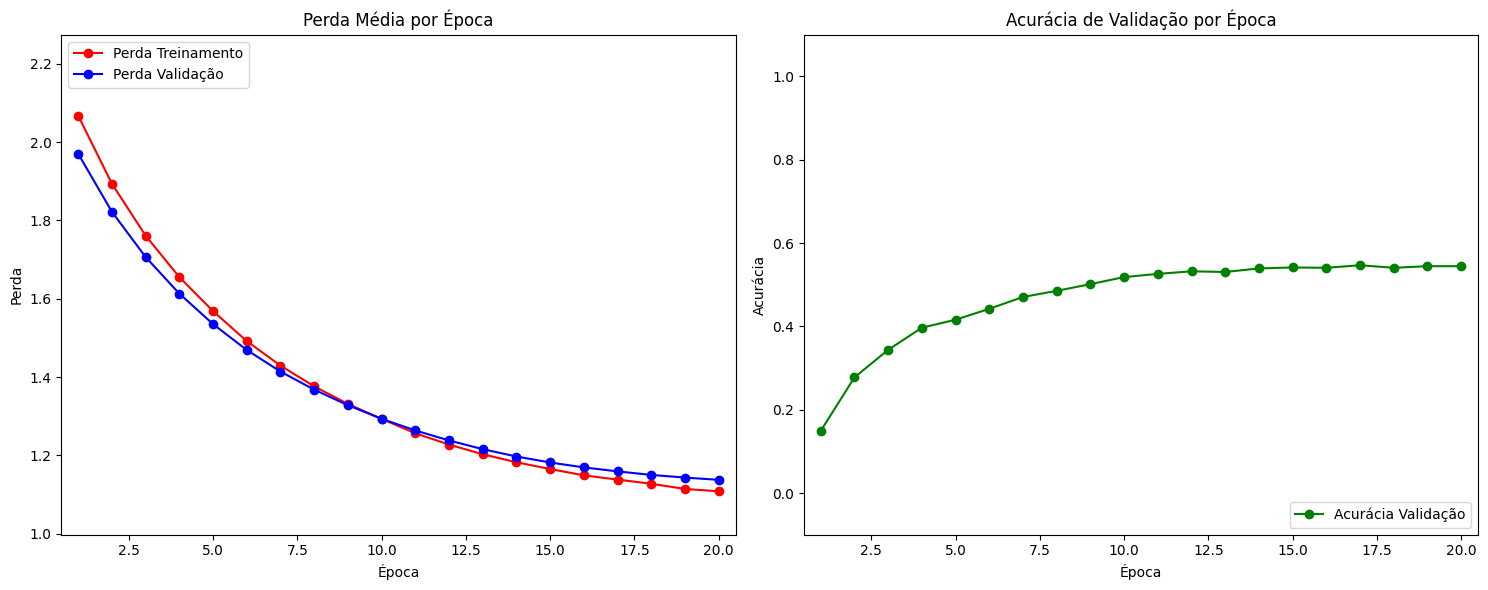

In [20]:
from torch import optim, nn


class WineModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = nn.Linear(12, 7)
        self.to(self.device)
    
    def forward(self, x):
        return self.model(x)
    
    def get_optimizer(self) -> optim.Optimizer:
        return optim.Adam(self.parameters())
    
    def get_loss_fn(self) -> nn.Module:
        return nn.CrossEntropyLoss()
    
model = WineModel()
analyze(model=model, num_epoches=20, vizualize_missmatch=False, visualize_cm=False)

--- Total de Épocas: 20 ---
--- Houveram 568/1_300 Exemplos classificados incorretamente ---
  Train loss: 1.0526
  Val loss: 1.0944
  Val Accuracy: 0.5631



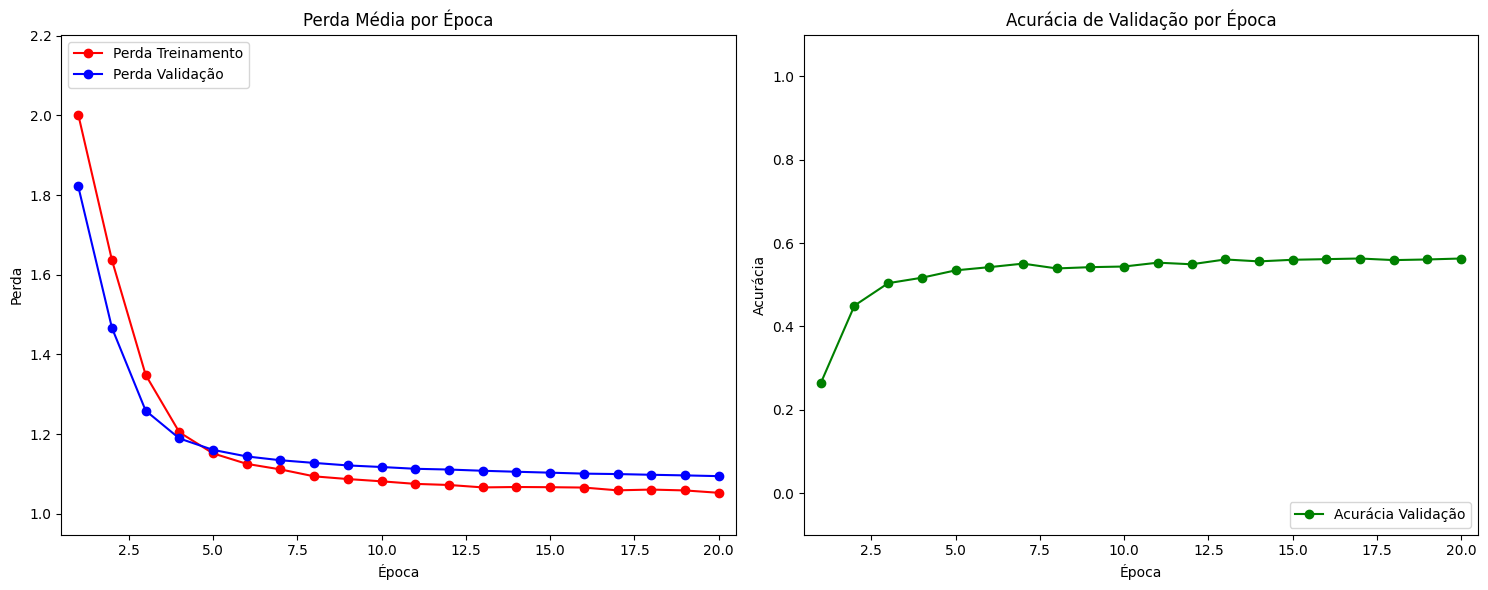

In [21]:
class WineModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = nn.Sequential(
            nn.Linear(12, 12),
            nn.ReLU(),  
            nn.Linear(12, 7)
        )
        self.to(self.device)
    
    def forward(self, x):
        return self.model(x)
    
    def get_optimizer(self) -> optim.Optimizer:
        return optim.Adam(self.parameters())
    
    def get_loss_fn(self) -> nn.Module:
        return nn.CrossEntropyLoss()
    
model = WineModel()
analyze(model=model, num_epoches=20, vizualize_missmatch=False, visualize_cm=False)

--- Total de Épocas: 20 ---
--- Houveram 574/1_300 Exemplos classificados incorretamente ---
  Train loss: 1.0921
  Val loss: 1.1064
  Val Accuracy: 0.5585



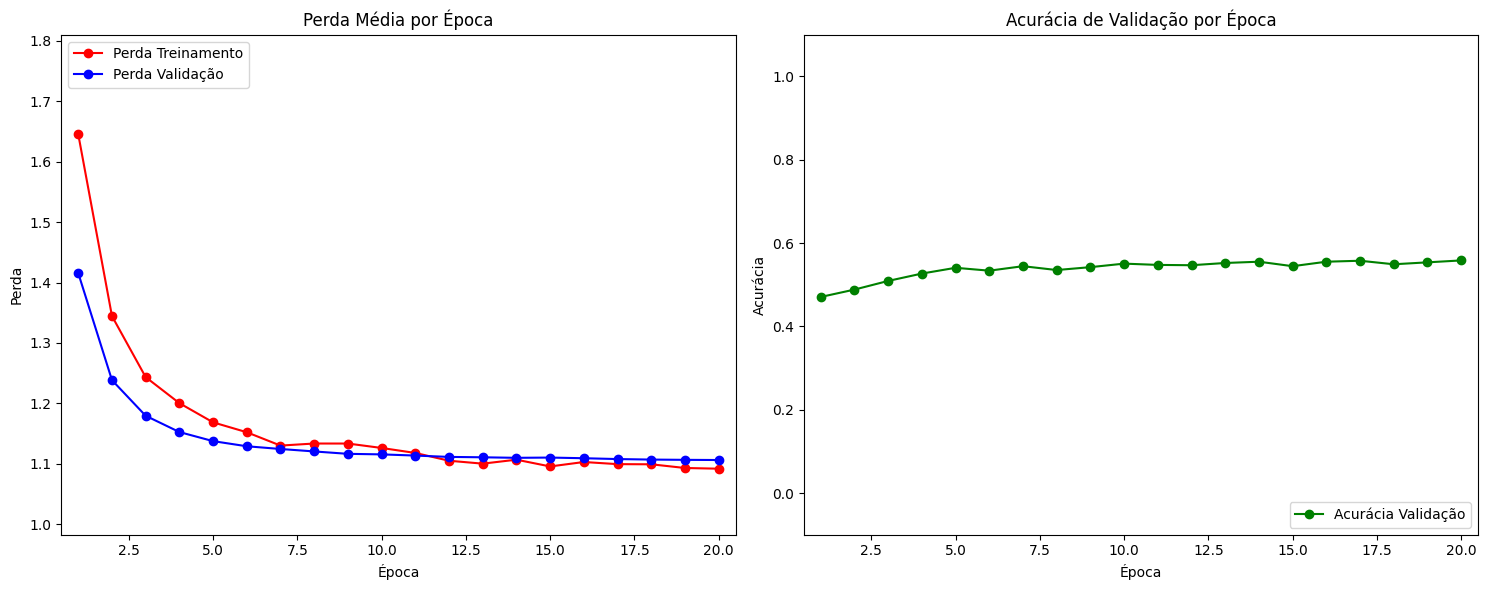

In [22]:
class WineModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5), 
            nn.Linear(32, 7)
        )
        self.to(self.device)
    
    def forward(self, x):
        return self.model(x)
    
    def get_optimizer(self) -> optim.Optimizer:
        return optim.Adam(self.parameters())
    
    def get_loss_fn(self) -> nn.Module:
        return nn.CrossEntropyLoss()
    
model = WineModel()
analyze(model=model, num_epoches=20, vizualize_missmatch=False, visualize_cm=False)


--- Total de Épocas: 20 ---
--- Houveram 601/1_300 Exemplos classificados incorretamente ---
  Train loss: 1.1241
  Val loss: 1.1181
  Val Accuracy: 0.5377



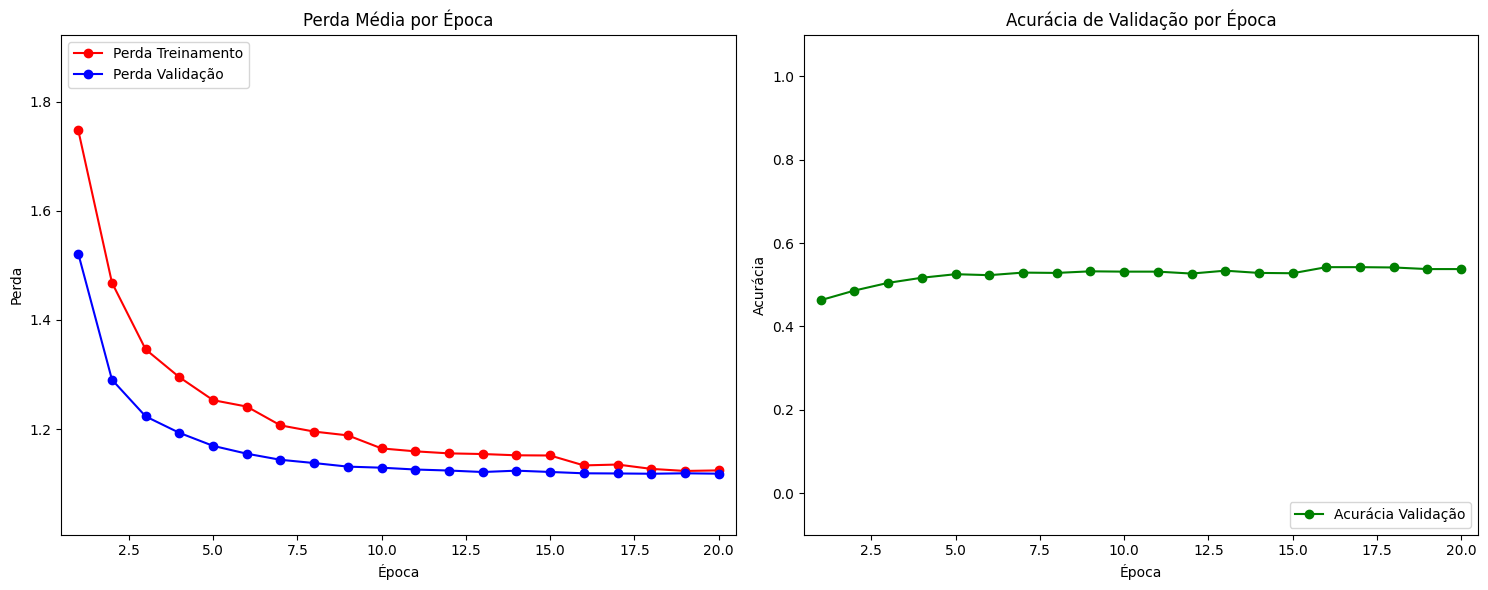

In [23]:
class WineModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(p=0.5),  
            nn.Linear(16, 7)
        )
        self.to(self.device)
    
    def forward(self, x):
        return self.model(x)
    
    def get_optimizer(self) -> optim.Optimizer:
        return optim.Adam(self.parameters())
    
    def get_loss_fn(self) -> nn.Module:
        return nn.CrossEntropyLoss()
    
model = WineModel()
analyze(model=model, num_epoches=20, vizualize_missmatch=False, visualize_cm=False)

## Considerações Finais sobre a Aplicação de MLPs ao Dataset Winequality

Após a experimentação com diferentes arquiteturas de Perceptron Multicamadas (MLPs) no dataset Winequality, observou-se que **não houve uma vantagem significativa ou ganho de desempenho considerável ao empregar redes neurais mais complexas** (com mais camadas ou mais neurônios) em comparação com modelos mais simples ou baselines.

Esta observação levanta algumas hipóteses e reflexões importantes:

1.  **Limitações do Dataset:**
    *   **Tamanho do Conjunto de Dados:** Uma possibilidade é que o dataset Winequality, embora útil para muitas análises, possa ser relativamente pequeno para treinar efetivamente modelos de MLP mais complexos sem que estes incorram em overfitting. Redes neurais com muitos parâmetros geralmente requerem grandes volumes de dados para aprender generalizações robustas.
    *   **Número e Natureza das Variáveis:** As features físico-químicas disponíveis no dataset, embora objetivas, podem não capturar toda a complexidade ou as nuances que definem a "qualidade" percebida de um vinho. Se as relações subjacentes entre essas features e a qualidade forem predominantemente lineares ou apenas moderadamente não-lineares, modelos mais simples podem ser suficientes, e a capacidade adicional dos MLPs mais complexos não encontra padrões adicionais para explorar.

2.  **Complexidade Intrínseca do Problema de Avaliação de Vinhos:**
    *   Conforme sugerido, a avaliação da qualidade de um vinho é um processo multifatorial e, muitas vezes, subjetivo. Enquanto o dataset se concentra em características mensuráveis, a percepção final de qualidade pelo consumidor pode ser influenciada por uma gama muito mais ampla de fatores.
    *   **Fatores Extrínsecos:** Elementos como a marca, a embalagem, a apresentação, o preço, e até mesmo o contexto de consumo (como mencionado na referência a estudos sobre o impacto da embalagem na apreciação) podem desempenhar um papel significativo na avaliação subjetiva, mas não estão presentes como features no dataset Winequality. Se estes fatores externos têm um peso considerável, os modelos treinados apenas com dados físico-químicos terão um teto natural em sua capacidade preditiva da "qualidade" como um todo.

**Em resumo:**

A ausência de melhoria com MLPs mais complexos no dataset Winequality sugere que, para as features disponíveis, modelos mais simples podem ser adequados e até preferíveis devido à menor propensão ao overfitting e menor custo computacional. Para capturar uma noção mais holística da "qualidade do vinho" que inclua aspectos subjetivos e extrínsecos, seria necessário um conjunto de dados mais abrangente ou uma formulação diferente do problema.

Este resultado não invalida a utilidade dos MLPs, mas destaca a importância crucial do "princípio da navalha de Occam" em machine learning: não se deve aumentar a complexidade do modelo desnecessariamente se modelos mais simples já oferecem um desempenho comparável ou adequado para o problema e os dados em questão.